In [ ]:
%%capture

!pip install datasets unidecode

## Finetune - French

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from unidecode import unidecode
import os


model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def prepare_dataset(examples):
    texts = examples['text']
    new_texts = []
    for text in texts:
        new_texts.append(text)
    return {'text': new_texts}


dataset = load_dataset('Sabrina1763/wikipedia_french', split='train[0:20000]')
dataset = dataset.map(prepare_dataset, batched=True)

def tokenize_function(examples):
    result = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    result['labels'] = result['input_ids'].clone()

    return result

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_dataset.set_format('torch')

training_args = TrainingArguments(
    output_dir='./gpt2-french',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=64,
    save_steps=100,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=100,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

trainer.train()
model.save_pretrained('./gpt2-french')
tokenizer.save_pretrained('./gpt2-french')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/540 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/240M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Step,Training Loss
100,3.705000
200,3.300400
300,3.193800


('./gpt2-french/tokenizer_config.json',
 './gpt2-french/special_tokens_map.json',
 './gpt2-french/vocab.json',
 './gpt2-french/merges.txt',
 './gpt2-french/added_tokens.json')

# load datasets

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline

base_model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load datasets
ds1 = load_dataset('wujohns/gpt2-base-learn', split="train[0:6000]")
ds2 = load_dataset('Sabrina1763/wikipedia_french', split='train[0:18000]')

# Create combined dataset with labels
combined_texts = []
combined_labels = []
for j in range(3):
    for i in ds1:
        combined_texts.append(i['text'])
        combined_labels.append(0)  # ds1 is better handled by base model
for i in ds2:
    combined_texts.append(i['text'])
    combined_labels.append(1)  # ds2 is better handled by fine-tuned model

print(f"Number of rows in combined_texts: {len(combined_texts)}")

dataset = Dataset.from_dict({"text": combined_texts, "label": combined_labels})

def tokenize_function(examples):
    outputs = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    return {'input_ids': outputs['input_ids'], 'attention_mask': outputs['attention_mask'], 'label': examples['label']}

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=[])
tokenized_datasets.set_format('torch')

sample_size = min(20000, len(tokenized_datasets))
train_dataset = tokenized_datasets.shuffle(seed=42).select(range(sample_size))

val_size = int(0.1 * sample_size)
train_dataset = train_dataset.select(range(sample_size - val_size))
val_dataset = tokenized_datasets.shuffle(seed=42).select(range(sample_size - val_size, sample_size))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Number of rows in combined_texts: 36000


Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

# Independent training

## Architecture

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline

torch.manual_seed(123)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model_name, fine_tuned_model_name = 'gpt2', './gpt2-french'  # Replace with your fine-tuned model path
base_model = GPT2LMHeadModel.from_pretrained(base_model_name).to(device)
fine_tuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_name).to(device)

# Set requires_grad to False for base and fine-tuned models
for model in [base_model, fine_tuned_model]:
    for param in model.parameters():
        param.requires_grad = False

num_layers = len(base_model.transformer.h)

class BSplineAlpha(nn.Module):
    def __init__(self, num_layers, num_control_points=16, degree=3):
        super().__init__()
        self.num_layers = num_layers
        self.num_control_points = num_control_points
        self.degree = degree
        # Initialize with rand-unif [0.3 - 0.7]
        self.control_points = nn.Parameter(torch.rand(num_control_points, device=device) * 0.1 + 0.45)
        # Add trainable bias term for each layer
        self.layer_biases = nn.Parameter(torch.zeros(num_layers, device=device))
        self.knot_vector = self._generate_knot_vector()
        self.register_buffer('basis_functions', self._compute_basis_functions())

    def _generate_knot_vector(self):
        num_knots = self.num_control_points + self.degree + 1
        knot_vector = np.linspace(0, 1, num_knots - 2 * self.degree)
        return np.concatenate((
            np.zeros(self.degree),
            knot_vector,
            np.ones(self.degree)
        ))

    def _compute_basis_functions(self):
        x = torch.linspace(0, 1, self.num_layers)
        basis_functions = np.zeros((self.num_layers, self.num_control_points))
        for i in range(self.num_control_points):
            coeffs = np.zeros(self.num_control_points)
            coeffs[i] = 1.0
            spline = BSpline(self.knot_vector, coeffs, self.degree)
            basis_functions[:, i] = spline(x.numpy())
        return torch.tensor(basis_functions, dtype=torch.float32, device=device)

    def forward(self):
        # Compute base alpha values from spline
        base_alpha_values = torch.matmul(self.basis_functions, self.control_points)
        # Add layer-specific biases and clamp
        alpha_values = torch.clamp(base_alpha_values + self.layer_biases * 0.1, 0.0, 1.0)
        return alpha_values

class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

class Conv1dWithPermute(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(Conv1dWithPermute, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        return x

class Autoencoder(nn.Module):
    def __init__(self, hidden_size, bottleneck_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(hidden_size, bottleneck_size),
            nn.GELU()
        )

        self.decoder = nn.Sequential(
            Conv1dWithPermute(
                in_channels=bottleneck_size,
                out_channels=hidden_size,
                kernel_size=3,
                padding=1
            ),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

hidden_size = base_model.config.n_embd
bottleneck_size = int(hidden_size * 0.75)

class MergedModel(nn.Module):
    def __init__(self, base_model, fine_tuned_model, alpha_module, autoencoders, autoencoder_layers=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]):
        super(MergedModel, self).__init__()
        self.base_model = base_model
        self.fine_tuned_model = fine_tuned_model
        self.alpha_module = alpha_module
        self.autoencoders = autoencoders
        self.autoencoder_layers = autoencoder_layers

    def forward(self, input_ids, attention_mask=None, output_hidden_states=False, return_dict=False):
        # Get alpha values with layer-wise biases
        alpha_values = self.alpha_module()

        # Get base model outputs
        base_outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
        base_hidden_states = base_outputs.hidden_states

        # Get fine-tuned model outputs
        fine_tuned_outputs = self.fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
        fine_tuned_hidden_states = fine_tuned_outputs.hidden_states

        # Blend hidden states and pass through autoencoders
        blended_hidden_states = []
        reconstructed_hidden_states = []

        for idx in range(len(base_hidden_states)):
            base_h = base_hidden_states[idx]
            fine_tuned_h = fine_tuned_hidden_states[idx]

            if idx == 0:
                # Embeddings layer, use average alpha
                alpha = torch.mean(alpha_values)
                blended_h = (1 - alpha) * base_h + alpha * fine_tuned_h
                blended_hidden_states.append(blended_h)
                reconstructed_hidden_states.append(blended_h)
            else:
                alpha = alpha_values[idx - 1]  # Adjust for embeddings at idx=0
                blended_h = (1 - alpha) * base_h + alpha * fine_tuned_h
                blended_hidden_states.append(blended_h)

                if (idx - 1) in self.autoencoder_layers:
                    h_recon = self.autoencoders[f"layer_{idx - 1}"](blended_h)
                    reconstructed_hidden_states.append(h_recon)
                else:
                    reconstructed_hidden_states.append(blended_h)

        # Compute final logits
        last_hidden_state = reconstructed_hidden_states[-1]
        logits = self.base_model.lm_head(last_hidden_state)

        output = {'logits': logits}
        if output_hidden_states:
            output['hidden_states'] = reconstructed_hidden_states
            output['blended_hidden_states'] = blended_hidden_states
            output['alpha_values'] = alpha_values  # Added to output for monitoring
        if return_dict:
            return output
        else:
            return logits

## Training loop

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

criterion_mse = nn.MSELoss()

torch.manual_seed(123)

alpha_module = BSplineAlpha(num_layers=num_layers).to(device)

# Define the layers where autoencoders will be applied (layers 2 to 7)
autoencoder_layers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Corresponds to the 3rd to n-th transformer blocks

# Initialize autoencoders only for the specified layers
autoencoders = nn.ModuleDict({
    f"layer_{layer_idx}": Autoencoder(hidden_size, bottleneck_size).to(device)
    for layer_idx in autoencoder_layers
})

# Initialize merged model with updated autoencoders
merged_model = MergedModel(base_model, fine_tuned_model, alpha_module, autoencoders, autoencoder_layers).to(device)

# Initialize optimizer
optimizer_params = [
    {'params': alpha_module.parameters(), 'lr': 2e-4},
    {'params': autoencoders.parameters(), 'lr': 1e-4}
]
optimizer = torch.optim.AdamW(optimizer_params, weight_decay=1e-2)

In [ ]:
num_epochs = 10
clip_value = 1.0

# Initialize lists to store losses
epoch_losses = []
epoch_lm_losses = []
epoch_recon_losses = []

for epoch in range(num_epochs):
    total_loss, total_lm_loss, total_recon_loss = 0, 0, 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = merged_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
        logits = outputs['logits']
        reconstructed_hidden_states = outputs['hidden_states']
        alpha_values = merged_model.alpha_module()

        # Language modeling loss computed with logits from reconstructed hidden states
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()
        lm_loss = nn.CrossEntropyLoss()(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # Compute reconstruction loss only for specified layers
        recon_loss = 0

        with torch.no_grad():
            base_outputs = base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
            base_hidden_states = base_outputs.hidden_states

            fine_tuned_outputs = fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
            fine_tuned_hidden_states = fine_tuned_outputs.hidden_states

        for idx in range(1, len(reconstructed_hidden_states)):  # Start from 1 to skip embeddings
            layer_idx = idx - 1  # Adjust for embeddings layer at idx=0
            if layer_idx in autoencoder_layers:
                h_recon = reconstructed_hidden_states[idx]  # idx corresponds to hidden state index
                # Get the target hidden state based on the label
                h_base = base_hidden_states[idx].detach()
                h_finetuned = fine_tuned_hidden_states[idx].detach()

                labels_expanded = labels.view(-1, 1, 1).float()
                target_hidden_state = h_base * (1 - labels_expanded) + h_finetuned * labels_expanded

                recon_loss_layer = criterion_mse(h_recon, target_hidden_state)
                recon_loss += recon_loss_layer

        # Adjusted loss scaling
        loss = recon_loss * 3.0 + lm_loss * 1.0  # You can adjust the weights as needed

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(autoencoders.parameters(), clip_value)
        torch.nn.utils.clip_grad_norm_(alpha_module.parameters(), clip_value)

        optimizer.step()

        total_loss += loss.item()
        total_lm_loss += lm_loss.item()
        total_recon_loss += recon_loss.item()

        progress_bar.set_postfix({
            'loss': f"{loss.item():.6f}",
            'lm_loss': f"{lm_loss.item():.6f}",
            'recon_loss': f"{recon_loss.item():.6f}"
        })

    avg_loss = total_loss / len(train_loader)
    avg_lm_loss = total_lm_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.6f}, Avg LM Loss: {avg_lm_loss:.6f}, Avg Recon Loss: {avg_recon_loss:.6f}")


print("\nTraining completed")

# recon_loss = 1080
# ETA 80min -> 22:50

Epoch 1/10: 100%|██████████| 563/563 [03:15<00:00,  2.88it/s, loss=85.300529, lm_loss=2.225962, recon_loss=27.691525]


Epoch 1/10, Avg Loss: 960.344140, Avg LM Loss: 5.048928, Avg Recon Loss: 318.431736


Epoch 2/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=53.986889, lm_loss=0.938156, recon_loss=17.682911]


Epoch 2/10, Avg Loss: 63.558513, Avg LM Loss: 1.339252, Avg Recon Loss: 20.739754


Epoch 3/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=38.221481, lm_loss=0.485699, recon_loss=12.578594]


Epoch 3/10, Avg Loss: 44.260325, Avg LM Loss: 0.634904, Avg Recon Loss: 14.541807


Epoch 4/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=35.796478, lm_loss=0.387496, recon_loss=11.802994]


Epoch 4/10, Avg Loss: 35.782477, Avg LM Loss: 0.416835, Avg Recon Loss: 11.788547


Epoch 5/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=30.851332, lm_loss=0.323401, recon_loss=10.175977]


Epoch 5/10, Avg Loss: 30.687761, Avg LM Loss: 0.319571, Avg Recon Loss: 10.122730


Epoch 6/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=26.095020, lm_loss=0.262341, recon_loss=8.610893]


Epoch 6/10, Avg Loss: 27.202901, Avg LM Loss: 0.264881, Avg Recon Loss: 8.979340


Epoch 7/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=21.577999, lm_loss=0.192204, recon_loss=7.128598]


Epoch 7/10, Avg Loss: 24.653362, Avg LM Loss: 0.230216, Avg Recon Loss: 8.141049


Epoch 8/10: 100%|██████████| 563/563 [03:15<00:00,  2.89it/s, loss=23.758745, lm_loss=0.226039, recon_loss=7.844235]


Epoch 8/10, Avg Loss: 22.714559, Avg LM Loss: 0.206153, Avg Recon Loss: 7.502802


Epoch 9/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=21.646093, lm_loss=0.213892, recon_loss=7.144067]


Epoch 9/10, Avg Loss: 21.174800, Avg LM Loss: 0.188358, Avg Recon Loss: 6.995481


Epoch 10/10: 100%|██████████| 563/563 [03:14<00:00,  2.89it/s, loss=19.780638, lm_loss=0.186662, recon_loss=6.531325]

Epoch 10/10, Avg Loss: 19.932860, Avg LM Loss: 0.175119, Avg Recon Loss: 6.585914

Training completed


## Quick Visualizations

In [ ]:
# Define models to evaluate
# Build the merged model
merged_model.eval()  # Set to evaluation mode

alpha_module.eval()
autoencoders.eval()

models_to_evaluate = {
    'base': base_model,
    'fine_tuned': fine_tuned_model,
    'merged_with_autoencoders': merged_model,
}

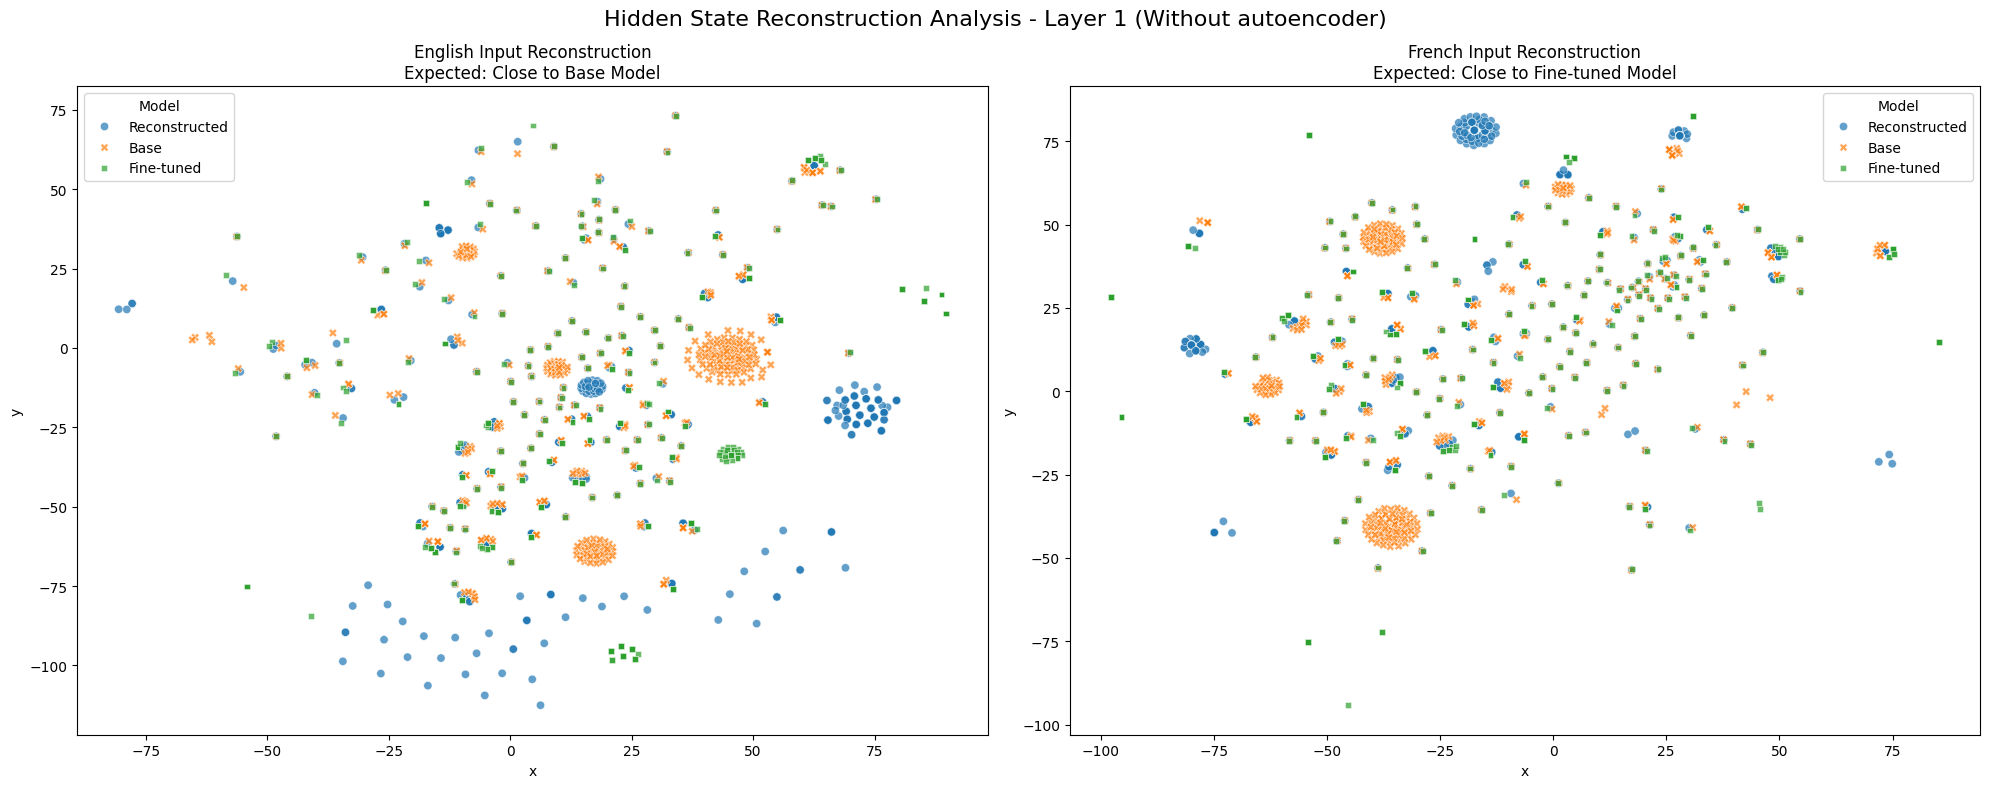

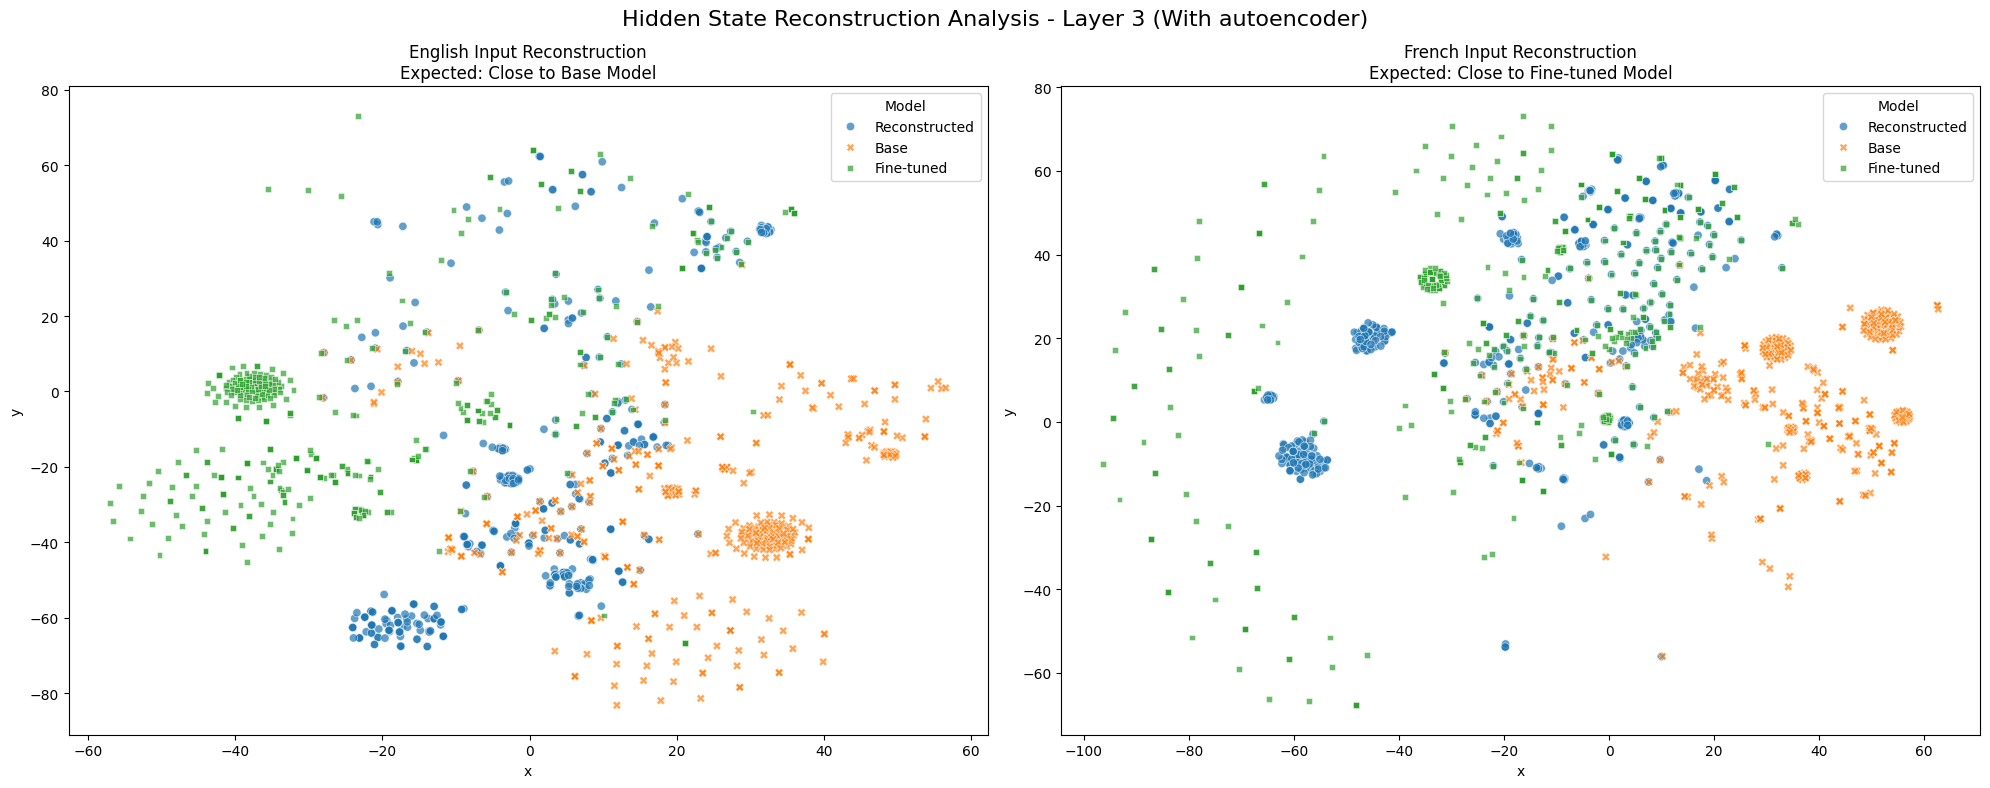

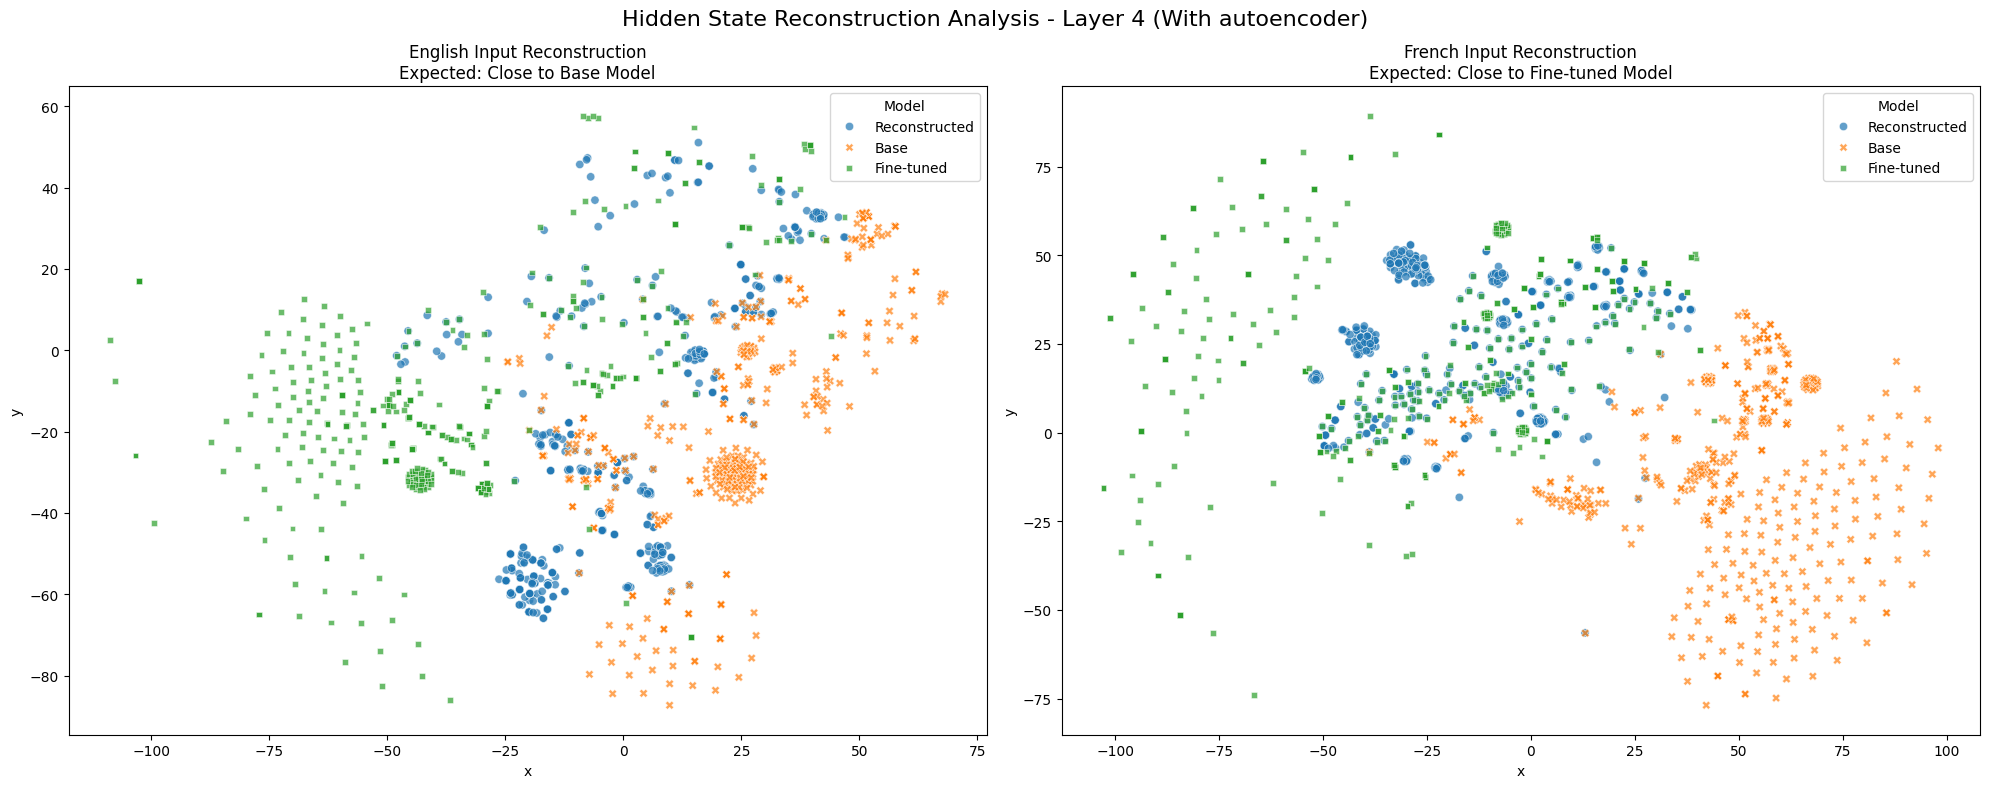

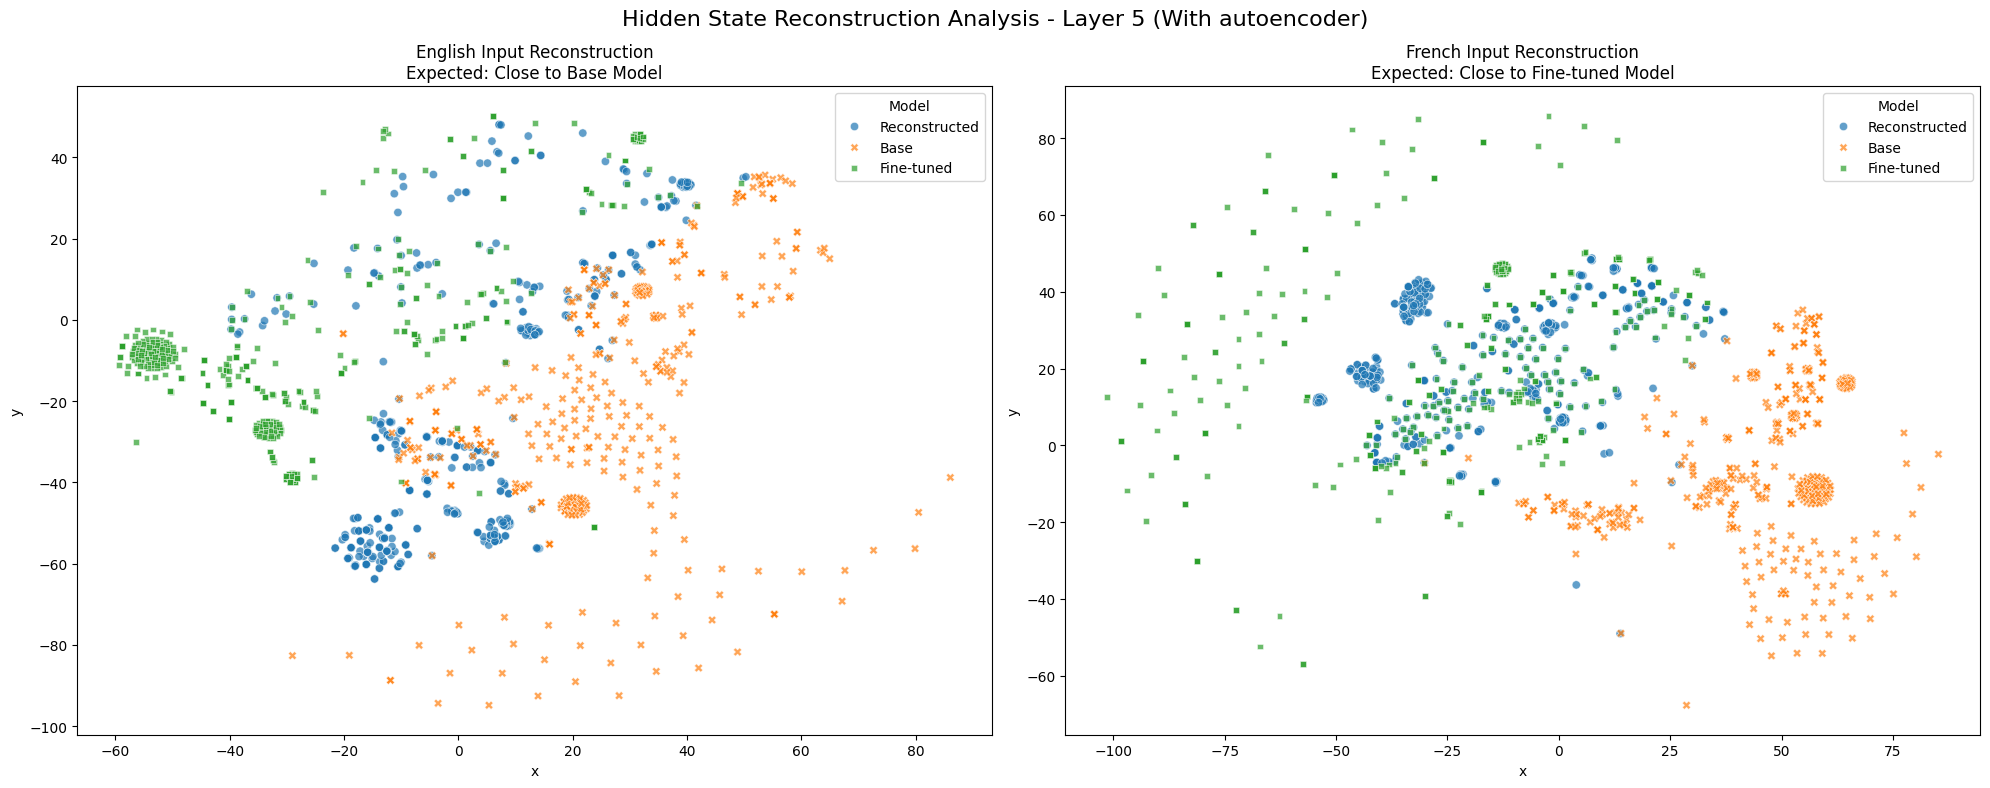

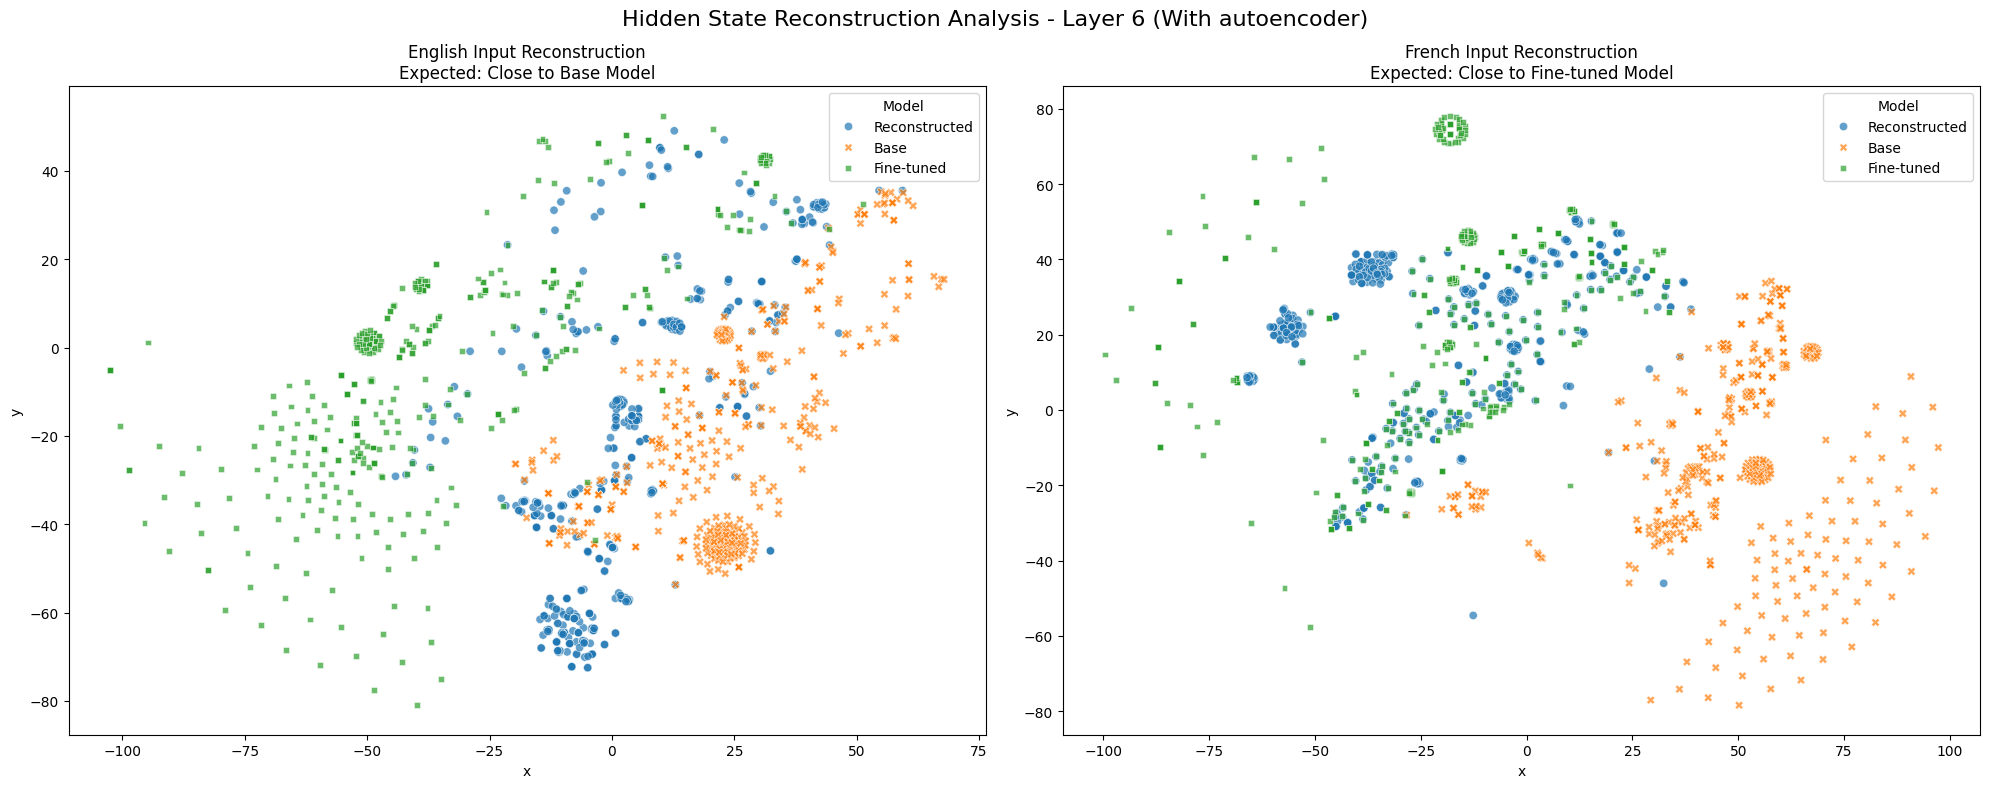

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from typing import Dict, List

def analyze_hidden_states(
    models: Dict[str, torch.nn.Module],
    eval_dataset,
    device: torch.device,
    num_samples: int = 1000,
    layer_indices: List[int] = [1, 3, 4, 5, 6, 9],
    selected_autoencoder_layers: List[int] = [3]
) -> None:
    """Analyze and visualize hidden states reconstruction using t-SNE."""

    dataloader = torch.utils.data.DataLoader(
        eval_dataset.shuffle(seed=42).select(range(num_samples)),
        batch_size=32,
        shuffle=False
    )

    # Store hidden states for each layer
    states_dict = {
        'reconstructed': {layer: [] for layer in layer_indices},
        'base': {layer: [] for layer in layer_indices},
        'fine_tuned': {layer: [] for layer in layer_indices}
    }
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['label']
            labels.extend(batch_labels.tolist())

            # Get hidden states from all models
            outputs_dict = {
                'reconstructed': models['merged_with_autoencoders'](
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                ),
                'base': models['base'](
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                ),
                'fine_tuned': models['fine_tuned'](
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                )
            }

            # Extract states for each layer
            for layer_idx in layer_indices:
                states_dict['reconstructed'][layer_idx].append(
                    outputs_dict['reconstructed']['hidden_states'][layer_idx][:, 0].cpu().numpy()
                )
                states_dict['base'][layer_idx].append(
                    outputs_dict['base'].hidden_states[layer_idx][:, 0].cpu().numpy()
                )
                states_dict['fine_tuned'][layer_idx].append(
                    outputs_dict['fine_tuned'].hidden_states[layer_idx][:, 0].cpu().numpy()
                )

    # Concatenate all batches
    for model_type in states_dict:
        for layer_idx in layer_indices:
            states_dict[model_type][layer_idx] = np.concatenate(states_dict[model_type][layer_idx])
    labels = np.array(labels)

    # Visualize each layer
    for layer_idx in layer_indices:
        visualize_reconstruction_comparison(
            states_dict['reconstructed'][layer_idx],
            states_dict['base'][layer_idx],
            states_dict['fine_tuned'][layer_idx],
            labels,
            layer_idx,
            with_autoencoder=True if layer_idx in selected_autoencoder_layers else False,
        )

def visualize_reconstruction_comparison(
    reconstructed: np.ndarray,
    base: np.ndarray,
    fine_tuned: np.ndarray,
    labels: np.ndarray,
    layer_idx: int,
    with_autoencoder: bool
) -> None:
    """Visualize hidden state reconstruction comparison using t-SNE."""

    # Combine all states for t-SNE
    combined_states = np.vstack([reconstructed, base, fine_tuned])

    # Create labels for the plot
    model_labels = (
        ['Reconstructed'] * len(reconstructed) +
        ['Base'] * len(base) +
        ['Fine-tuned'] * len(fine_tuned)
    )
    language_labels = (['English' if l == 0 else 'French' for l in labels] * 3)

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    embedded = tsne.fit_transform(combined_states)

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'x': embedded[:, 0],
        'y': embedded[:, 1],
        'Model': model_labels,
        'Language': language_labels
    })

    # Create separate plots for English and French
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    suffix_ = 'With' if with_autoencoder else 'Without'
    fig.suptitle(f'Hidden State Reconstruction Analysis - Layer {layer_idx} ({suffix_} autoencoder)', fontsize=16)

    # English samples
    eng_df = df[df['Language'] == 'English']
    sns.scatterplot(
        data=eng_df,
        x='x', y='y',
        hue='Model',
        style='Model',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_title('English Input Reconstruction\nExpected: Close to Base Model')

    # French samples
    fr_df = df[df['Language'] == 'French']
    sns.scatterplot(
        data=fr_df,
        x='x', y='y',
        hue='Model',
        style='Model',
        alpha=0.7,
        ax=ax2
    )
    ax2.set_title('French Input Reconstruction\nExpected: Close to Fine-tuned Model')

    plt.tight_layout()
    plt.show()

analyze_hidden_states(
    models=models_to_evaluate,
    eval_dataset=val_dataset,
    device=device,
    layer_indices = [1, 3, 4, 5, 6],
    selected_autoencoder_layers=[3, 4, 5, 6]
)

## Export

In [ ]:
# Build the merged model
merged_model.eval()  # Set to evaluation mode

alpha_module.eval()
autoencoders.eval()

# Save the trained alpha_module and autoencoders
torch.save({
    'alpha_module_state_dict': alpha_module.state_dict(),
    'autoencoders_state_dict': autoencoders.state_dict(),
}, 'merged_model_params.pt')

print("Model parameters saved to merged_model_params.pt")

Model parameters saved to merged_model_params.pt


# Inference

## Inference architecture

In [ ]:
class MergedModel(nn.Module):
    def __init__(self, base_model, fine_tuned_model, alpha_module, autoencoders):
        super(MergedModel, self).__init__()
        self.base_model = base_model
        self.fine_tuned_model = fine_tuned_model
        self.alpha_module = alpha_module
        self.autoencoders = autoencoders

        # Assuming both models share the same configuration
        self.config = base_model.config

        # Extract transformer blocks from both models
        self.base_blocks = base_model.transformer.h
        self.fine_tuned_blocks = fine_tuned_model.transformer.h

        # Store both base and fine-tuned embeddings
        self.base_wte = base_model.transformer.wte  # Base token embeddings
        self.base_wpe = base_model.transformer.wpe  # Base position embeddings
        self.ft_wte = fine_tuned_model.transformer.wte  # Fine-tuned token embeddings
        self.ft_wpe = fine_tuned_model.transformer.wpe  # Fine-tuned position embeddings

        self.drop = base_model.transformer.drop  # Dropout layer
        self.ln_f = base_model.transformer.ln_f  # Final layer norm

        # Language modeling head
        self.lm_head = base_model.lm_head

    def forward(self, input_ids, attention_mask=None, output_hidden_states=False, return_dict=False):
        device = input_ids.device

        alpha_values = self.alpha_module()

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        # Prepare attention mask
        batch_size, seq_length = input_ids.size()
        causal_mask = torch.tril(torch.ones((seq_length, seq_length), device=device)).unsqueeze(0).unsqueeze(0)
        attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
        attention_mask = attention_mask * causal_mask
        attention_mask = attention_mask.to(dtype=self.base_model.dtype)  # For fp16 compatibility
        attention_mask = (1.0 - attention_mask) * -10000.0  # Masked positions

        # Compute all embeddings at once and average
        position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        base_embeddings_state = self.base_wte(input_ids) + self.base_wpe(position_ids)
        fine_embeddings_state = self.ft_wte(input_ids) + self.ft_wpe(position_ids)

        alpha = torch.mean(alpha_values)
        hidden_states = (1 - alpha) * base_embeddings_state + alpha * fine_embeddings_state

        hidden_states = self.drop(hidden_states)

        if output_hidden_states:
            all_hidden_states = [hidden_states]

        # Sequentially pass through transformer blocks and autoencoders
        num_layers = len(self.base_blocks)

        all_blended_hidden_states = []
        for idx in range(num_layers):
            base_block = self.base_blocks[idx]
            fine_tuned_block = self.fine_tuned_blocks[idx]

            # Base and fine-tuned outputs
            base_outputs = base_block(hidden_states, attention_mask=attention_mask)
            base_hidden_states = base_outputs[0]

            fine_tuned_outputs = fine_tuned_block(hidden_states, attention_mask=attention_mask)
            fine_tuned_hidden_states = fine_tuned_outputs[0]

            # Blend hidden states
            alpha = alpha_values[idx]
            alpha = alpha.view(1, 1, -1)
            blended_hidden_state = (1 - alpha) * base_hidden_states + alpha * fine_tuned_hidden_states

            all_blended_hidden_states.append(blended_hidden_state)
            # Pass through autoencoder
            autoencoder_idx = idx  # Index matches the layer index

            # Apply autoencoder only to specified layers
            selected_autoencoder_layers = [2, 3, 4, 5, 6, 7, 8, 9, 10]
            if autoencoder_idx in selected_autoencoder_layers:
                reconstructed_hidden_state = self.autoencoders[f"layer_{autoencoder_idx}"](blended_hidden_state)
            else:
                reconstructed_hidden_state = blended_hidden_state

            # Input for the next layer
            hidden_states = reconstructed_hidden_state

            if output_hidden_states:
                all_hidden_states.append(hidden_states)

        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        if output_hidden_states:
            all_hidden_states.append(hidden_states)

        # Compute logits
        logits = self.lm_head(hidden_states)

        if not return_dict:
            return logits

        outputs = {'logits': logits}
        if output_hidden_states:
            outputs['hidden_states'] = all_hidden_states
            outputs['blended_hidden_states'] = all_blended_hidden_states
        return outputs

## Load checkpoints

In [ ]:
checkpoint = torch.load('merged_model_params.pt', map_location=device)
alpha_module.load_state_dict(checkpoint['alpha_module_state_dict'])
autoencoders.load_state_dict(checkpoint['autoencoders_state_dict'])

# Initialize merged model with updated autoencoders
merged_model = MergedModel(base_model, fine_tuned_model, alpha_module, autoencoders).to(device)

# Print current alpha values
print("\nCurrent alpha values:")
alpha_values = merged_model.alpha_module().detach().cpu().numpy()
print(alpha_values)


Current alpha values:
[0.45149335 0.73330534 0.7788051  0.7791315  0.7795674  0.7907663
 0.796664   0.80197287 0.7964326  0.7974785  0.8075395  0.8586762 ]


<ipython-input-5-62330c74f6bf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('merged_model_params.pt', map_location=device)


## Generate

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline



def generate_predictions(model, tokenizer, prompt, max_length=50, num_samples=3, temperature=0.7, device='cuda'):

    model.eval()
    generated_texts = []

    # Encode the prompt
    encoded_prompt = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        for _ in range(num_samples):
            # Initialize sequence with prompt
            current_sequence = encoded_prompt.clone()

            for _ in range(max_length):
                # Get model outputs
                outputs = model(input_ids=current_sequence, return_dict=True)
                next_token_logits = outputs['logits'][:, -1, :] / temperature

                # Sample next token
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                # Append next token to sequence
                current_sequence = torch.cat([current_sequence, next_token], dim=1)

                # Stop if we hit the EOS token
                if next_token[0].item() == tokenizer.eos_token_id:
                    break

            # Decode the generated sequence
            generated_text = tokenizer.decode(current_sequence[0], skip_special_tokens=True)
            generated_texts.append(generated_text)

    return generated_texts

# Test prompts for different scenarios
test_prompts = [
    "The history of France begins with",  # French history (fine-tuned model territory)
    "The quick brown fox",  # English general text (base model territory)
    "Le château de Versailles",  # French landmark (fine-tuned model territory)
    "The economy has been developing, cependent la majorite"
]


# Generate predictions for each test prompt
print("\nGenerating predictions for test prompts:")
for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    predictions = generate_predictions(
        merged_model,
        tokenizer,
        prompt,
        max_length=50,
        num_samples=2,
        temperature=0.9,
        device=device
    )
    for idx, pred in enumerate(predictions, 1):
        print(f"Sample {idx}: {pred}")

# Print current alpha values
print("\nCurrent alpha values:")
alpha_values = merged_model.alpha_module().detach().cpu().numpy()
print(alpha_values)


Generating predictions for test prompts:

Prompt: The history of France begins with
Sample 1: The history of France begins with the U.S. Army until as much of the country of about 37,000 and we will and that work as well. I did a lot of the construction and the people in HPR Center and it's the military part of the city.
Sample 2: The history of France begins with various estimates" that it may, in part, between. but the like -- the "unknown and readily available jobs in the tech industry. And in the case of what that is a response to these problems. Australia didn't end up with the Earth

Prompt: The quick brown fox
Sample 1: The quick brown fox make sure to. That's more in the political system.
Sample 2: The quick brown fox normally along with the other Oman. Encuda makes an effort to end-of-season and can only provide tension.No-accusation-wise.
UPDATE -

Prompt: Le château de Versailles
Sample 1: Le château de Versailles-Dos Racins, islee fourois. Sans telepoint du Château de Vers

# Evaluation

In [ ]:
%%capture
!pip install torchmetrics
!pip install umap-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import BSpline

import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics.text import BLEUScore
from torchmetrics.text.rouge import ROUGEScore

from collections import defaultdict
from typing import List, Dict

from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

import logging
import umap.umap_ as umap
UMAP_AVAILABLE = True


# Implement standard merging approach (weight averaging)
def average_models(model1, model2):
    merged_model = GPT2LMHeadModel.from_pretrained(base_model_name).to(device)
    merged_state_dict = merged_model.state_dict()
    model1_state_dict = model1.state_dict()
    model2_state_dict = model2.state_dict()

    for param_name in merged_state_dict.keys():
        param1 = model1_state_dict[param_name]
        param2 = model2_state_dict[param_name]
        merged_param = (param1 + param2) / 2
        merged_state_dict[param_name].copy_(merged_param)

    merged_model.load_state_dict(merged_state_dict)
    return merged_model

averaged_model = average_models(base_model, fine_tuned_model)


In [ ]:
models_to_evaluate = {
    'base': base_model,
    'fine_tuned': fine_tuned_model,
    'merged_with_autoencoders': merged_model,
    'merged_with_addition':  averaged_model,
}

Computing distances: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


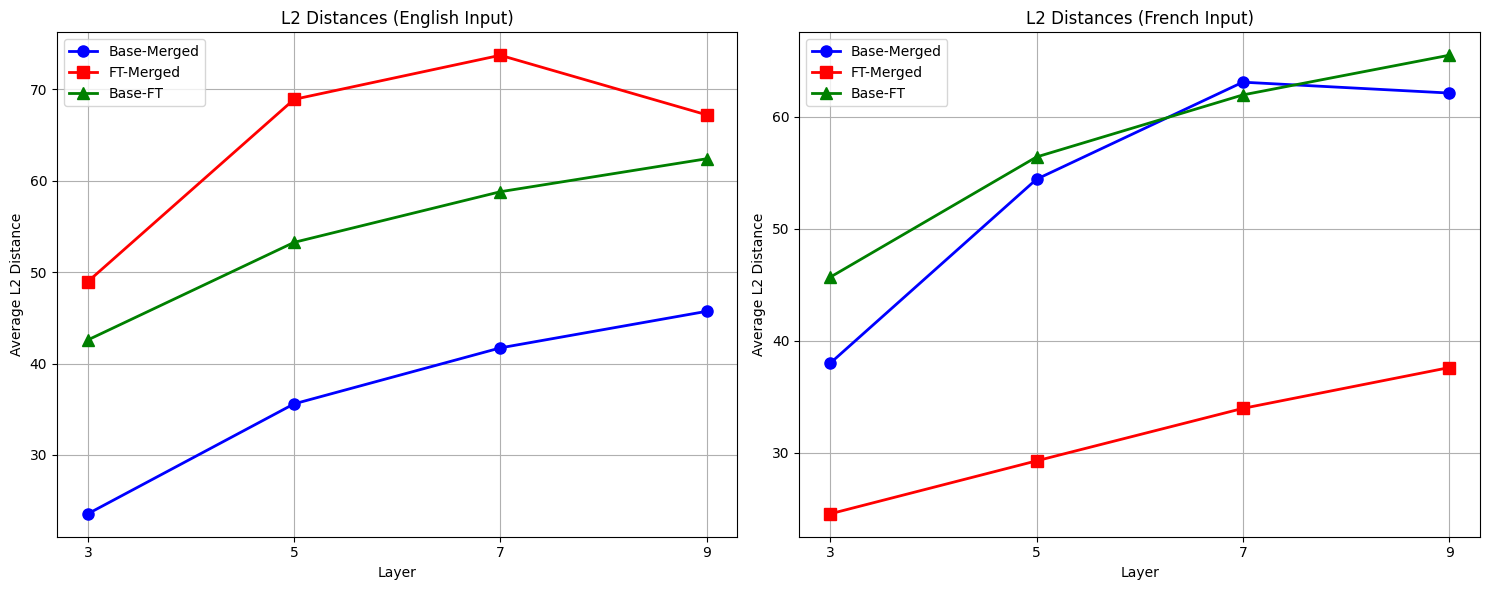


Analyzing layers: [3, 5, 7, 9]

Average L2 Distances per Language:

English:
  Base-Merged: 36.6420
  FT-Merged: 64.6945
  Base-FT: 54.2549

French:
  Base-Merged: 54.4043
  FT-Merged: 31.3303
  Base-FT: 57.3804


In [ ]:
def analyze_hidden_state_distances(
    merged_model,
    base_model,
    fine_tuned_model,
    eval_dataset,
    tokenizer,
    device,
    layers_to_analyze=None,
    num_samples=500,
    batch_size=32
):
    """
    Analyze L2 distances between all three models' hidden states.

    Args:
        layers_to_analyze: List of layer indices to analyze. If None, analyzes all layers.
    """
    # Clear any existing plots
    plt.close('all')

    dataloader = DataLoader(
        eval_dataset.shuffle(seed=42).select(range(num_samples)),
        batch_size=batch_size,
        shuffle=False,
    )

    # Get total number of layers and determine which to analyze
    total_layers = len(merged_model.base_model.transformer.h)
    if layers_to_analyze is None:
        layers_to_analyze = list(range(total_layers))
    else:
        # Ensure layers are within valid range and sorted
        layers_to_analyze = sorted([l for l in layers_to_analyze if 0 <= l < total_layers])
        if not layers_to_analyze:
            raise ValueError("No valid layers specified for analysis")

    # Initialize dictionaries to store results per layer
    layer_results = {i: {
        'english': {
            'base_merged_diff': [],
            'ft_merged_diff': [],
            'base_ft_diff': [],
            'count': 0
        },
        'french': {
            'base_merged_diff': [],
            'ft_merged_diff': [],
            'base_ft_diff': [],
            'count': 0
        }
    } for i in layers_to_analyze}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing distances"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].cpu().numpy()

            merged_outputs = merged_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
            )

            base_outputs = base_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
            )

            fine_tuned_outputs = fine_tuned_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
            )

            for idx in range(len(labels)):
                for layer in layers_to_analyze:
                    merged_state = merged_outputs['hidden_states'][layer + 1][idx, 0].cpu().numpy()
                    base_state = base_outputs.hidden_states[layer + 1][idx, 0].cpu().numpy()
                    ft_state = fine_tuned_outputs.hidden_states[layer + 1][idx, 0].cpu().numpy()

                    base_merged_diff = np.linalg.norm(base_state - merged_state)
                    ft_merged_diff = np.linalg.norm(ft_state - merged_state)
                    base_ft_diff = np.linalg.norm(base_state - ft_state)

                    lang_key = 'english' if labels[idx] == 0 else 'french'
                    layer_results[layer][lang_key]['base_merged_diff'].append(base_merged_diff)
                    layer_results[layer][lang_key]['ft_merged_diff'].append(ft_merged_diff)
                    layer_results[layer][lang_key]['base_ft_diff'].append(base_ft_diff)
                    layer_results[layer][lang_key]['count'] += 1

    # Calculate averages
    for layer in layer_results:
        for lang in ['english', 'french']:
            if layer_results[layer][lang]['count'] > 0:
                for key in ['base_merged_diff', 'ft_merged_diff', 'base_ft_diff']:
                    values = layer_results[layer][lang][key]
                    layer_results[layer][lang][key] = np.mean(values)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^']

    # Plot English distances
    english_diffs = {
        'Base-Merged': [layer_results[i]['english']['base_merged_diff'] for i in layers_to_analyze],
        'FT-Merged': [layer_results[i]['english']['ft_merged_diff'] for i in layers_to_analyze],
        'Base-FT': [layer_results[i]['english']['base_ft_diff'] for i in layers_to_analyze]
    }

    for (label, diffs), color, marker in zip(english_diffs.items(), colors, markers):
        ax1.plot(layers_to_analyze, diffs, color=color, label=label,
                marker=marker, linewidth=2, markersize=8)

    ax1.set_title('L2 Distances (English Input)')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Average L2 Distance')
    ax1.legend()
    ax1.grid(True)
    # Set x-axis ticks to match analyzed layers
    ax1.set_xticks(layers_to_analyze)

    # Plot French distances
    french_diffs = {
        'Base-Merged': [layer_results[i]['french']['base_merged_diff'] for i in layers_to_analyze],
        'FT-Merged': [layer_results[i]['french']['ft_merged_diff'] for i in layers_to_analyze],
        'Base-FT': [layer_results[i]['french']['base_ft_diff'] for i in layers_to_analyze]
    }

    for (label, diffs), color, marker in zip(french_diffs.items(), colors, markers):
        ax2.plot(layers_to_analyze, diffs, color=color, label=label,
                marker=marker, linewidth=2, markersize=8)

    ax2.set_title('L2 Distances (French Input)')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Average L2 Distance')
    ax2.legend()
    ax2.grid(True)
    # Set x-axis ticks to match analyzed layers
    ax2.set_xticks(layers_to_analyze)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print(f"\nAnalyzing layers: {layers_to_analyze}")
    print("\nAverage L2 Distances per Language:")
    for lang in ['english', 'french']:
        print(f"\n{lang.capitalize()}:")
        base_merged_avg = np.mean([layer_results[i][lang]['base_merged_diff'] for i in layers_to_analyze])
        ft_merged_avg = np.mean([layer_results[i][lang]['ft_merged_diff'] for i in layers_to_analyze])
        base_ft_avg = np.mean([layer_results[i][lang]['base_ft_diff'] for i in layers_to_analyze])

        print(f"  Base-Merged: {base_merged_avg:.4f}")
        print(f"  FT-Merged: {ft_merged_avg:.4f}")
        print(f"  Base-FT: {base_ft_avg:.4f}")

    return layer_results

# Example usage with specific layers:
selected_layers = [3, 5, 7, 9]
results = analyze_hidden_state_distances(
    merged_model=merged_model,
    base_model=base_model,
    fine_tuned_model=fine_tuned_model,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    device=device,
    layers_to_analyze=selected_layers,
    num_samples=500
)

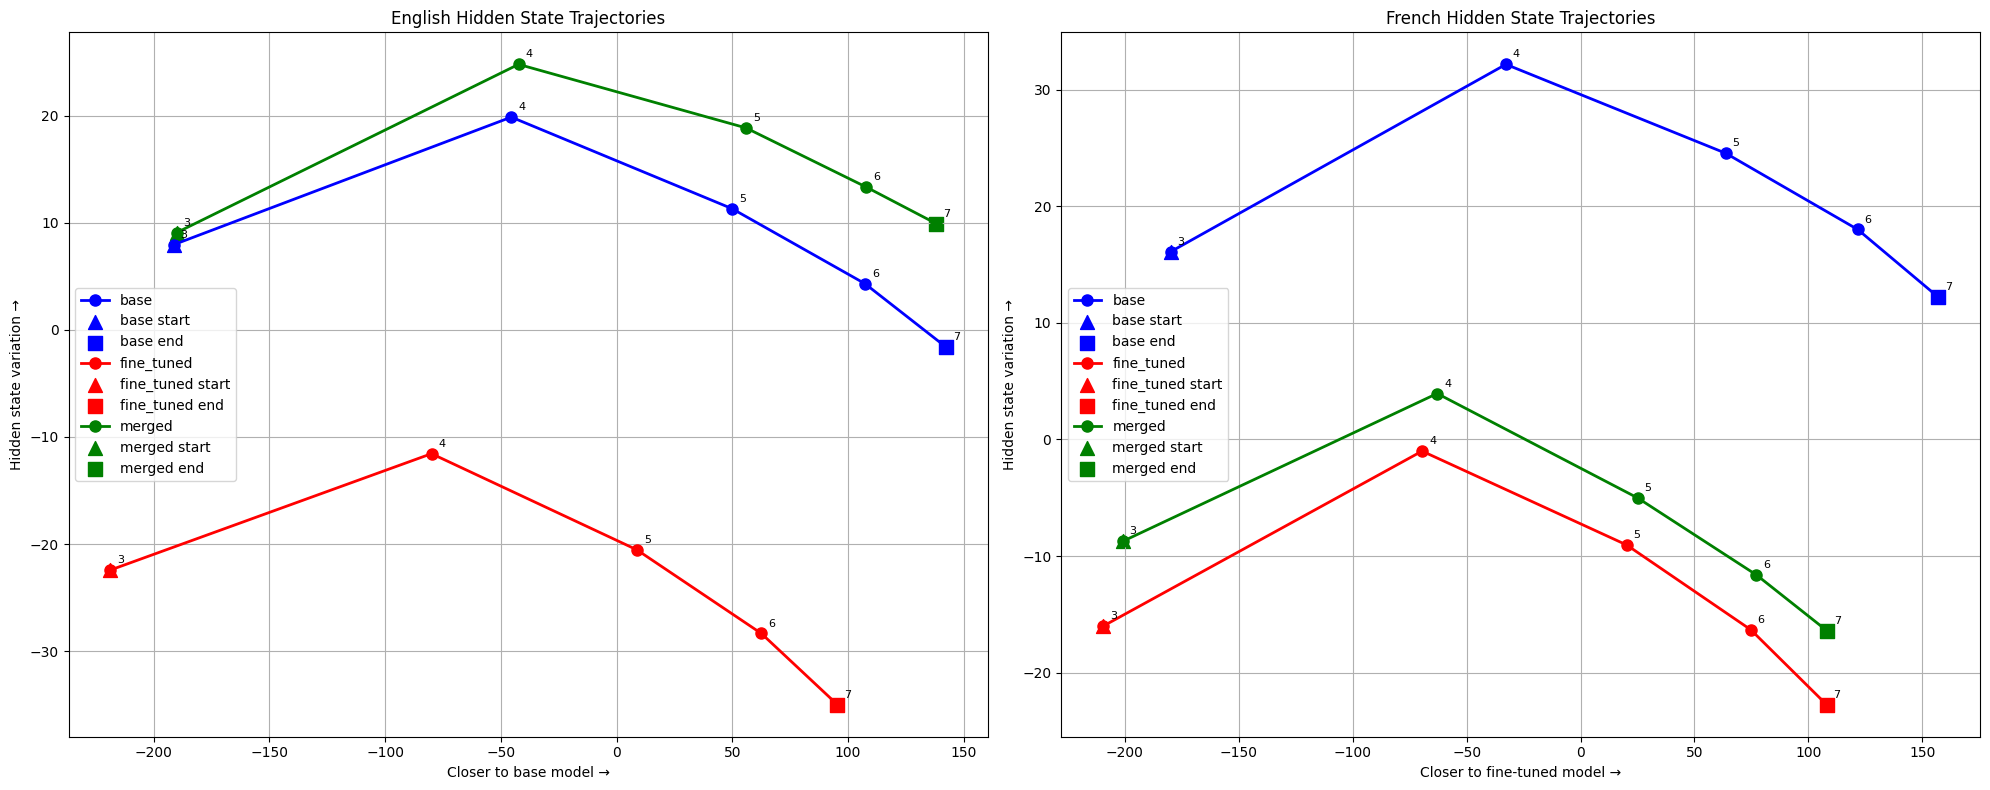

In [ ]:
def analyze_hidden_state_trajectories(
    merged_model,
    base_model,
    fine_tuned_model,
    eval_dataset,
    tokenizer,
    device,
    layers_to_analyze=None,
    num_samples=500,
    batch_size=32,
):
    """
    Visualize hidden state trajectories where distances between lines represent
    similarities between hidden states.
    """
    plt.close('all')

    dataloader = DataLoader(
        eval_dataset.shuffle(seed=42).select(range(num_samples)),
        batch_size=batch_size,
        shuffle=False,
    )

    total_layers = len(merged_model.base_model.transformer.h)
    if layers_to_analyze is None:
        layers_to_analyze = list(range(total_layers))
    else:
        layers_to_analyze = sorted([l for l in layers_to_analyze if 0 <= l < total_layers])
        if not layers_to_analyze:
            raise ValueError("No valid layers specified for analysis")

    # Initialize storage for hidden states
    hidden_states = {
        'english': {
            'base': [[] for _ in layers_to_analyze],
            'fine_tuned': [[] for _ in layers_to_analyze],
            'merged': [[] for _ in layers_to_analyze]
        },
        'french': {
            'base': [[] for _ in layers_to_analyze],
            'fine_tuned': [[] for _ in layers_to_analyze],
            'merged': [[] for _ in layers_to_analyze]
        }
    }

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting hidden states"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].cpu().numpy()

            # Get outputs from all models
            merged_outputs = merged_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
            )
            base_outputs = base_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
            )
            fine_tuned_outputs = fine_tuned_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
            )

            for idx, label in enumerate(labels):
                lang_key = 'english' if label == 0 else 'french'

                for i, layer in enumerate(layers_to_analyze):
                    # Get hidden states for each model
                    merged_state = merged_outputs['hidden_states'][layer + 1][idx, 0].cpu().numpy()
                    base_state = base_outputs.hidden_states[layer + 1][idx, 0].cpu().numpy()
                    ft_state = fine_tuned_outputs.hidden_states[layer + 1][idx, 0].cpu().numpy()

                    hidden_states[lang_key]['merged'][i].append(merged_state)
                    hidden_states[lang_key]['base'][i].append(base_state)
                    hidden_states[lang_key]['fine_tuned'][i].append(ft_state)

    # Average hidden states per layer
    for lang in hidden_states:
        for model in hidden_states[lang]:
            for i in range(len(layers_to_analyze)):
                hidden_states[lang][model][i] = np.mean(hidden_states[lang][model][i], axis=0)

    # Create plots for English and French
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    colors = {'base': 'blue', 'fine_tuned': 'red', 'merged': 'green'}

    for lang, ax in [('english', ax1), ('french', ax2)]:
        # Stack all hidden states for dimensionality reduction
        all_states = []
        for model in ['base', 'fine_tuned', 'merged']:
            for layer_states in hidden_states[lang][model]:
                all_states.append(layer_states)
        all_states = np.array(all_states)

        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)

        reduced_states = reducer.fit_transform(all_states)

        # Plot trajectories
        for model_idx, model in enumerate(['base', 'fine_tuned', 'merged']):
            start_idx = model_idx * len(layers_to_analyze)
            end_idx = start_idx + len(layers_to_analyze)
            trajectory = reduced_states[start_idx:end_idx]

            # Plot main line
            ax.plot(trajectory[:, 0], trajectory[:, 1],
                   color=colors[model], label=f'{model}',
                   linewidth=2, marker='o', markersize=8)

            # Add layer numbers
            for i, (x, y) in enumerate(trajectory):
                ax.annotate(f'{layers_to_analyze[i]}',
                          (x, y),
                          xytext=(5, 5),
                          textcoords='offset points',
                          fontsize=8)

            # Highlight start and end points
            ax.scatter(trajectory[0, 0], trajectory[0, 1],
                      color=colors[model], s=100,
                      marker='^', label=f'{model} start')
            ax.scatter(trajectory[-1, 0], trajectory[-1, 1],
                      color=colors[model], s=100,
                      marker='s', label=f'{model} end')

        ax.set_title(f'{lang.capitalize()} Hidden State Trajectories')
        ax.legend()
        ax.grid(True)

        # Add relative distance annotations
        if lang == 'english':
            ax.set_xlabel("Closer to base model →")
        else:
            ax.set_xlabel("Closer to fine-tuned model →")
        ax.set_ylabel("Hidden state variation →")

    plt.tight_layout()
    plt.show()

selected_layers = [3, 4, 5, 6, 7]
analyze_hidden_state_trajectories(
    merged_model=merged_model,
    base_model=base_model,
    fine_tuned_model=fine_tuned_model,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    device=device,
    layers_to_analyze=selected_layers,
    num_samples=500,
)

## Additional Metrics

Computing hidden state MSE loss: 100%|██████████| 4/4 [00:00<00:00, 25.85it/s]


Combined Results:
{'perplexity': {'english': {'base': 28.879929, 'fine_tuned': 54.419685, 'merged': 43.14546}, 'french': {'base': 132.02406, 'fine_tuned': 29.574469, 'merged': 33.203808}}, 'diversity_metrics': {'english': {'base': {'Distinct-1': 0.3452054794520548, 'Distinct-2': 0.5359116022099447, 'Self-BLEU': 0.8773390374969242, 'Unigram Entropy': 7.538515816440918, 'Bigram Entropy': 8.532803117072959}, 'fine_tuned': {'Distinct-1': 0.3474576271186441, 'Distinct-2': 0.51994301994302, 'Self-BLEU': 0.9118393152331074, 'Unigram Entropy': 7.538301169868337, 'Bigram Entropy': 8.457799211036084}, 'merged': {'Distinct-1': 0.34615384615384615, 'Distinct-2': 0.53601108033241, 'Self-BLEU': 0.8826931475457548, 'Unigram Entropy': 7.466444937242493, 'Bigram Entropy': 8.523363384937875}}, 'french': {'base': {'Distinct-1': 0.4365079365079365, 'Distinct-2': 0.5564516129032258, 'Self-BLEU': 0.830310513028442, 'Unigram Entropy': 5.526107420924669, 'Bigram Entropy': 6.034841471677191}, 'fine_tuned': {'D

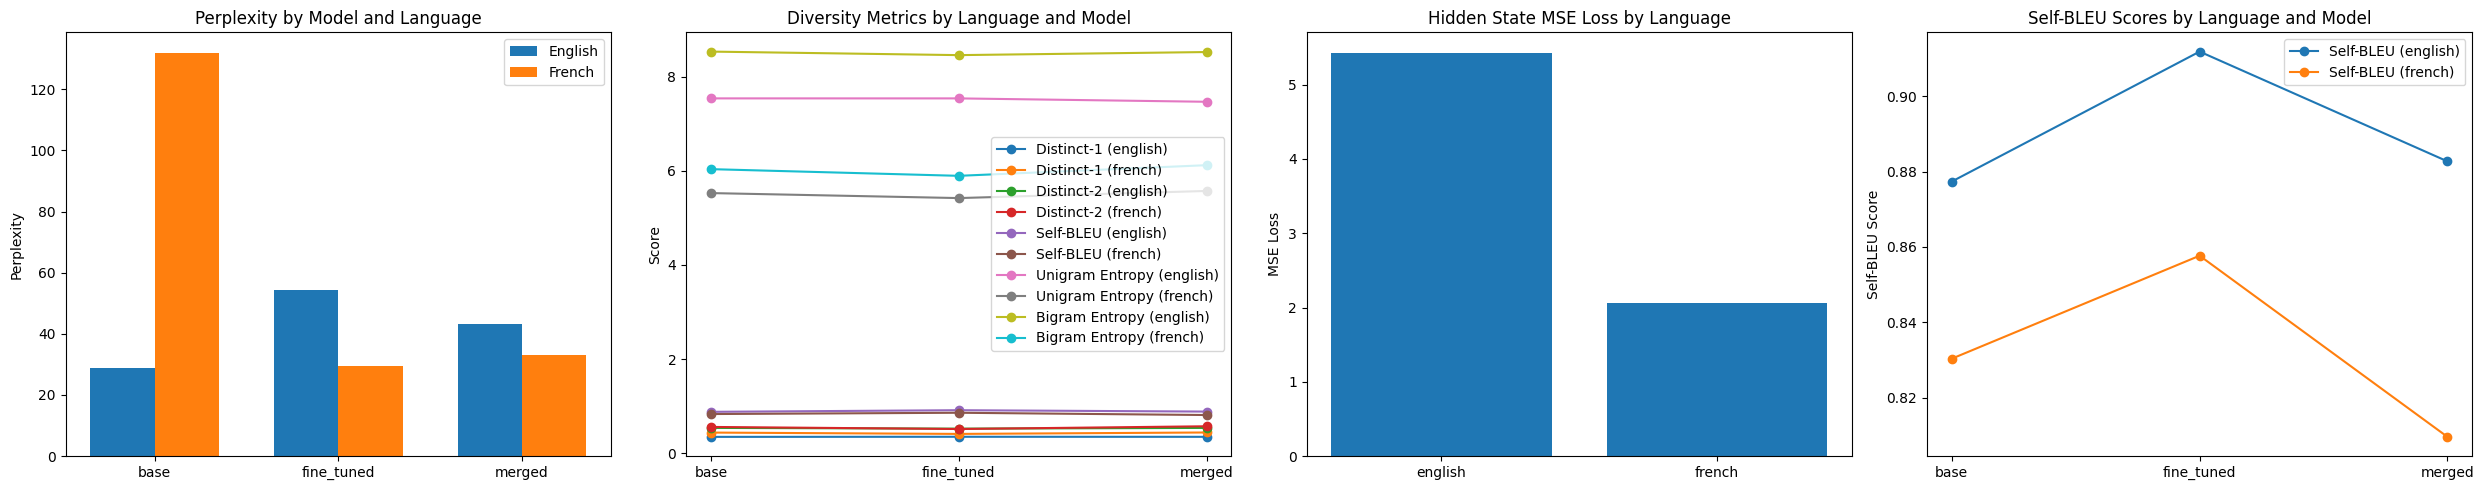

In [ ]:
import torch
import torch.nn.functional as F
from typing import Dict, List
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import PreTrainedModel, PreTrainedTokenizer
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter
import math

class MergeEvaluator:
    def __init__(
        self,
        base_model: PreTrainedModel,
        fine_tuned_model: PreTrainedModel,
        merged_model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        device: torch.device
    ):
        self.base_model = base_model.to(device)
        self.fine_tuned_model = fine_tuned_model.to(device)
        self.merged_model = merged_model.to(device)
        self.tokenizer = tokenizer
        self.device = device

    def evaluate_perplexity(
        self,
        dataset,
        batch_size: int = 16,
        num_samples: int = 1000
    ) -> Dict[str, Dict[str, float]]:
        """
        Evaluate perplexity across all models for both English and French inputs.
        """
        models = {
            'base': self.base_model,
            'fine_tuned': self.fine_tuned_model,
            'merged': self.merged_model
        }

        results = {'english': {}, 'french': {}}
        dataloader = DataLoader(
            dataset.shuffle(seed=42).select(range(num_samples)),
            batch_size=batch_size,
            shuffle=False
        )

        for model_name, model in models.items():
            english_losses = []
            french_losses = []

            model.eval()
            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"Computing perplexity for {model_name}"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['label'].cpu().numpy()

                    # Compute outputs
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        return_dict=True
                    )
                    logits = outputs["logits"]

                    # Shift logits and labels
                    shift_logits = logits[:, :-1, :].contiguous()
                    shift_labels = input_ids[:, 1:].contiguous()
                    shift_attention_mask = attention_mask[:, 1:].contiguous()

                    # Compute loss per token per batch
                    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
                    loss = loss_fct(
                        shift_logits.view(-1, shift_logits.size(-1)),
                        shift_labels.view(-1)
                    )
                    # Apply attention mask
                    loss = loss * shift_attention_mask.view(-1)
                    # Reshape loss back to [batch_size, seq_len]
                    loss = loss.view(input_ids.size(0), -1)

                    # Sum loss per sequence
                    seq_loss = loss.sum(dim=1) / shift_attention_mask.sum(dim=1)
                    seq_loss = seq_loss.cpu().numpy()

                    for idx in range(len(seq_loss)):
                        if labels[idx] == 0:  # English
                            english_losses.append(seq_loss[idx])
                        else:  # French
                            french_losses.append(seq_loss[idx])

            # Calculate perplexity from mean loss
            results['english'][model_name] = np.exp(np.mean(english_losses))
            results['french'][model_name] = np.exp(np.mean(french_losses))

        return results

    def evaluate_diversity_metrics(
        self,
        dataset,
        num_samples: int = 100,
        max_new_tokens: int = 50,
        num_samples_per_prompt: int = 3,
        temperature: float = 0.7
    ) -> Dict[str, Dict[str, Dict[str, float]]]:
        """
        Evaluate diversity of the generated texts using Distinct-N, Self-BLEU, and N-gram Entropy metrics.
        """
        models = {
            'base': self.base_model,
            'fine_tuned': self.fine_tuned_model,
            'merged': self.merged_model
        }

        results = {'english': {}, 'french': {}}

        for model_name, model in models.items():
            model.eval()
            # Initialize separate counts for English and French
            all_unigrams = {'english': [], 'french': []}
            all_bigrams = {'english': [], 'french': []}
            total_unigrams = {'english': 0, 'french': 0}
            total_bigrams = {'english': 0, 'french': 0}
            generated_texts = {'english': [], 'french': []}

            for idx in tqdm(range(num_samples), desc=f"Generating text with {model_name}"):
                sample = dataset[idx]
                # input_ids = torch.tensor(sample['input_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
                # attention_mask = torch.tensor(sample['attention_mask'], dtype=torch.long).unsqueeze(0).to(self.device)
                input_ids = sample['input_ids'].clone().detach().unsqueeze(0).to(self.device)
                attention_mask = sample['attention_mask'].clone().detach().unsqueeze(0).to(self.device)
                label = sample['label']  # Assuming 'label' is 0 for English, 1 for French

                # Get the initial prompt text
                prompt_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

                # Generate predictions
                gen_texts = self.generate_predictions(
                    model,
                    prompt_text,
                    max_new_tokens=max_new_tokens,
                    num_samples=num_samples_per_prompt,
                    temperature=temperature
                )

                # For each generated text, collect unigrams and bigrams according to language
                lang = 'english' if label == 0 else 'french'

                for generated_text in gen_texts:
                    tokens = generated_text.split()
                    total_unigrams[lang] += len(tokens)
                    total_bigrams[lang] += max(len(tokens) - 1, 0)
                    all_unigrams[lang].extend(tokens)
                    all_bigrams[lang].extend(zip(tokens[:-1], tokens[1:]))
                    generated_texts[lang].append(tokens)

            # Compute distinct metrics, Self-BLEU, and N-gram entropy for each language
            for lang in ['english', 'french']:
                distinct_1 = len(set(all_unigrams[lang])) / total_unigrams[lang] if total_unigrams[lang] > 0 else 0
                distinct_2 = len(set(all_bigrams[lang])) / total_bigrams[lang] if total_bigrams[lang] > 0 else 0

                # Compute Self-BLEU
                self_bleu_scores = self.compute_self_bleu(generated_texts[lang])
                avg_self_bleu = np.mean(self_bleu_scores) if self_bleu_scores else 0

                # Compute N-gram entropy
                unigram_entropy = self.compute_ngram_entropy(all_unigrams[lang])
                bigram_entropy = self.compute_ngram_entropy(all_bigrams[lang])

                if model_name not in results[lang]:
                    results[lang][model_name] = {}

                results[lang][model_name]['Distinct-1'] = distinct_1
                results[lang][model_name]['Distinct-2'] = distinct_2
                results[lang][model_name]['Self-BLEU'] = avg_self_bleu
                results[lang][model_name]['Unigram Entropy'] = unigram_entropy
                results[lang][model_name]['Bigram Entropy'] = bigram_entropy

        return results

    def compute_self_bleu(self, generated_texts: List[List[str]]) -> List[float]:
        """
        Compute Self-BLEU scores for a list of generated texts.
        """
        self_bleu_scores = []
        total_texts = len(generated_texts)
        for i in range(total_texts):
            references = generated_texts[:i] + generated_texts[i+1:]
            # Flatten references
            references = [ref for ref in references if ref]
            if not references:
                continue
            score = sentence_bleu(references, generated_texts[i], weights=(0.25, 0.25, 0.25, 0.25))
            self_bleu_scores.append(score)
        return self_bleu_scores

    def compute_ngram_entropy(self, ngrams_list: List):
        """
        Compute the entropy of n-grams in the list.
        """
        ngram_counts = Counter(ngrams_list)
        total_ngrams = sum(ngram_counts.values())
        entropy = 0.0
        for count in ngram_counts.values():
            p = count / total_ngrams
            entropy -= p * math.log(p, 2)
        return entropy

    def generate_predictions(
        self,
        model,
        prompt,
        max_new_tokens=50,
        num_samples=3,
        temperature=0.7
    ):
        """
        Generate text using manual token-by-token generation.
        """
        model.eval()
        generated_texts = []

        # Encode the prompt
        encoded_prompt = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        with torch.no_grad():
            for _ in range(num_samples):
                # Initialize sequence with prompt
                current_sequence = encoded_prompt.clone()

                for _ in range(max_new_tokens):
                    # Get model outputs
                    outputs = model(input_ids=current_sequence, return_dict=True)
                    next_token_logits = outputs["logits"][:, -1, :] / temperature

                    # Sample next token
                    probs = torch.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)

                    # Append next token to sequence
                    current_sequence = torch.cat([current_sequence, next_token], dim=1)

                    # Stop if we hit the EOS token
                    if next_token.item() == self.tokenizer.eos_token_id:
                        break

                # Decode the generated sequence
                generated_text = self.tokenizer.decode(current_sequence[0], skip_special_tokens=True)
                generated_texts.append(generated_text)

        return generated_texts

    def compute_hidden_state_mse(
        self,
        dataset,
        num_samples: int = 100
    ) -> Dict[str, Dict[str, float]]:
        """
        Compute MSE loss between hidden states, separately for English and French.
        """
        mse_losses = {'english': [], 'french': []}

        for idx in tqdm(range(num_samples), desc="Computing hidden state MSE loss"):
            sample = dataset[idx]
            # input_ids = torch.tensor(sample['input_ids'], dtype=torch.long).unsqueeze(0).to(self.device)
            input_ids = sample['input_ids'].clone().detach().unsqueeze(0).to(self.device)
            # attention_mask = torch.tensor(sample['attention_mask'], dtype=torch.long).unsqueeze(0).to(self.device)
            attention_mask = sample['attention_mask'].clone().detach().unsqueeze(0).to(self.device)
            label = sample['label']  # Assuming 'label' is 0 or 1

            # Get hidden states from each model
            with torch.no_grad():
                outputs_base = self.base_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                )
                outputs_ft = self.fine_tuned_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                )
                outputs_merged = self.merged_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True
                )

            # Use the last hidden state
            h_base = outputs_base.hidden_states[-1]  # Shape: [1, seq_len, hidden_size]
            h_ft = outputs_ft.hidden_states[-1]
            h_merged = outputs_merged["hidden_states"][-1]

            # Compute target hidden state as in training loop
            label_tensor = torch.tensor([label], dtype=torch.float32).to(self.device)
            labels_expanded = label_tensor.view(-1, 1, 1)
            target_hidden_state = h_base * (1 - labels_expanded) + h_ft * labels_expanded

            # Compute MSE loss between merged model's hidden state and target hidden state
            mse_loss = torch.nn.functional.mse_loss(h_merged, target_hidden_state)
            lang = 'english' if label == 0 else 'french'
            mse_losses[lang].append(mse_loss.item())

        # Compute average MSE loss
        average_mse_loss = {
            'english': np.mean(mse_losses['english']),
            'french': np.mean(mse_losses['french'])
        }

        return {'merged_model_mse_loss': average_mse_loss}

    def evaluate_all(
        self,
        dataset,
        batch_size: int = 16,
        num_samples: int = 1000,
        generation_samples: int = 100,
        max_new_tokens: int = 50,
        num_samples_per_prompt: int = 3,
        temperature: float = 0.7
    ) -> Dict[str, Dict[str, Dict[str, float]]]:
        """
        Run all evaluations and return combined results.
        """
        perplexity_results = self.evaluate_perplexity(
            dataset=dataset,
            batch_size=batch_size,
            num_samples=num_samples
        )

        diversity_results = self.evaluate_diversity_metrics(
            dataset=dataset,
            num_samples=generation_samples,
            max_new_tokens=max_new_tokens,
            num_samples_per_prompt=num_samples_per_prompt,
            temperature=temperature
        )

        mse_loss_result = self.compute_hidden_state_mse(
            dataset=dataset,
            num_samples=generation_samples
        )

        # Combine all results
        combined_results = {
            'perplexity': perplexity_results,
            'diversity_metrics': diversity_results,
            'hidden_state_mse': mse_loss_result
        }

        return combined_results

    def visualize_results(
        self,
        combined_results: Dict[str, Dict[str, Dict[str, float]]]
    ):
        """
        Visualize the evaluation results.
        """
        # Perplexity results
        perplexity_results = combined_results['perplexity']
        models = list(perplexity_results['english'].keys())
        x = np.arange(len(models))
        width = 0.35

        fig, axs = plt.subplots(1, 4, figsize=(25, 5))

        # Perplexity comparison
        axs[0].bar(x - width/2, [perplexity_results['english'][m] for m in models], width, label='English')
        axs[0].bar(x + width/2, [perplexity_results['french'][m] for m in models], width, label='French')
        axs[0].set_ylabel('Perplexity')
        axs[0].set_title('Perplexity by Model and Language')
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(models)
        axs[0].legend()

        # Diversity metrics
        diversity_results = combined_results['diversity_metrics']
        metrics = ['Distinct-1', 'Distinct-2', 'Self-BLEU', 'Unigram Entropy', 'Bigram Entropy']
        languages = ['english', 'french']

        for metric_idx, metric in enumerate(metrics):
            for lang in languages:
                values = [diversity_results[lang][model][metric] for model in models]
                axs[1].plot(models, values, marker='o', label=f"{metric} ({lang})")
        axs[1].set_title('Diversity Metrics by Language and Model')
        axs[1].legend()
        axs[1].set_ylabel('Score')
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(models)

        # Hidden state MSE loss
        mse_loss = combined_results['hidden_state_mse']['merged_model_mse_loss']
        x_mse = np.arange(len(languages))
        mse_values = [mse_loss[lang] for lang in languages]
        axs[2].bar(x_mse, mse_values, tick_label=languages)
        axs[2].set_title('Hidden State MSE Loss by Language')
        axs[2].set_ylabel('MSE Loss')

        # Self-BLEU Scores
        for lang in languages:
            values = [diversity_results[lang][model]['Self-BLEU'] for model in models]
            axs[3].plot(models, values, marker='o', label=f"Self-BLEU ({lang})")
        axs[3].set_title('Self-BLEU Scores by Language and Model')
        axs[3].legend()
        axs[3].set_ylabel('Self-BLEU Score')
        axs[3].set_xticks(x)
        axs[3].set_xticklabels(models)

        plt.tight_layout()
        plt.show()


# Instantiate the evaluator
evaluator = MergeEvaluator(
    base_model=base_model,
    fine_tuned_model=fine_tuned_model,
    merged_model=merged_model,
    tokenizer=tokenizer,
    device=device
)

# Run all evaluations
combined_results = evaluator.evaluate_all(
    dataset=val_dataset,
    batch_size=2,
    num_samples=4,
    generation_samples=4,
    max_new_tokens=20,
    num_samples_per_prompt=2,
    temperature=0.7
)

# Print and visualize the results
print("Combined Results:")
print(combined_results)

evaluator.visualize_results(combined_results)